In [1]:
%load_ext Cython

In [2]:
%%cython 

import networkx as nx
import numpy as np
cimport numpy as np

np.random.seed(2017)

def construct_adjlist():
    g = nx.barabasi_albert_graph(n=30, m=3,seed=2017)

    adjlist = nx.generate_adjlist(g, delimiter=",")
    adjlist = [np.array([eval(x)]).flatten() for x in adjlist]

    lens = [len(x) for x in adjlist]
    maxlen = max(lens)
    n = g.number_of_nodes()

    adjlist_m = np.ones([n, maxlen], dtype = np.int32) * (-1)

    for nn in range(n):
        adjlist_m[nn, :lens[nn]] = adjlist[nn]

    return adjlist_m

adjlist_m = construct_adjlist()


cdef _info_spread(np.ndarray[np.int32_t, ndim=2] adjlist_m, \
                np.ndarray[np.int32_t, ndim=2] states):  
    cdef int N = adjlist_m.shape[0]
    cdef float p = 0.2
    cdef float lamda = 0.9
    cdef Py_ssize_t n_i,n_j
    cdef np.ndarray[np.int32_t, ndim = 1] nn_S = np.zeros(N, dtype=np.int32)
    cdef np.ndarray[np.float32_t, ndim = 1] alpha_nS = np.zeros(N, dtype=np.float32)
    cdef np.ndarray[np.int32_t, ndim=2] new_states = states
    
    for n_i in range(N):
        for n_j in adjlist_m[n_i,:]:
            if n_j == -1:
                continue
            nn_S[n_i] += states[n_j,0]  
            
    alpha_nS = np.tanh(nn_S/2.0, dtype=np.float32) # when n_s = 4, alpha -> 1
    
    for n_i in range(N):
        if states[n_i,2] == 1:
            # n_i is 'R'
            continue
        if states[n_i,1] == 1:
            # n_i is 'I'
            if np.random.random() < alpha_nS[n_i]*p:
                # I-->S
                new_states[n_i,1] = 0
                new_states[n_i,0] = 1
            elif np.random.random() < alpha_nS[n_i]*(1-p):
                # I-->R
                new_states[n_i,1] = 0
                new_states[n_i,2] = 1
        else:
            assert(states[n_i,0] == 1)
            # n_i is 'S'
            if np.random.random() < lamda:
                # S -> R
                new_states[n_i,0] = 0
                new_states[n_i,2] = 1
    
    return new_states


def InfoSpread(np.ndarray[np.int32_t, ndim = 2]adjlist_m, int tmax):
    cdef int N = adjlist_m.shape[0]
    cdef np.ndarray[np.int32_t, ndim = 2] states = np.zeros([N,3],dtype=np.int32)
    cdef np.ndarray[np.int32_t, ndim = 2] statistics = np.zeros([tmax,3],dtype=np.int32)
    cdef np.ndarray[np.int32_t, ndim = 3] all_states = np.zeros([tmax,N,3],dtype=np.int32)
     
    # set Ignorants and seeds
    states[:,1] = 1
    states[0:5,0] = 1
#     new_states = states
    
    for t in range(tmax):
        statistics[t,:] = np.sum(states, axis=0)
        if statistics[t,0] == 0:
            return statistics
        all_states[t] = states
        states = _info_spread(adjlist_m, states)
    return all_states



    

In [3]:
all_states = InfoSpread(adjlist_m, 20)

[ 0.8  0.2  0.8  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]


/Users/qinglingzhang/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/qinglingzhang/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/qinglingzhang/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/qinglingzhang/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0


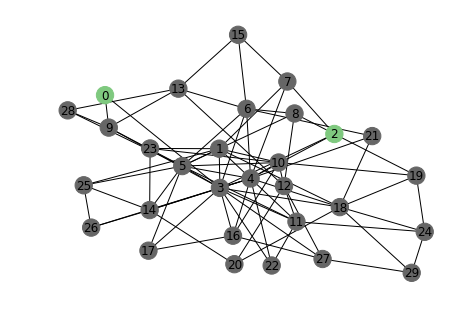

In [4]:
import networkx as nx
import matplotlib.pyplot as plt 

%matplotlib inline

G_BA = nx.barabasi_albert_graph(n=30, m=3,seed=2017)

N =30
node_attribute = np.zeros(N)


for i in range(N):
    if all_states[10,i,0] == 1:
        node_attribute[i] = 0.2
    elif all_states[10,i,1] == 1:
        node_attribute[i] = 0.2
    else:
        node_attribute[i] = 0.8
        
print(node_attribute)
nx.draw(G_BA, pos=nx.spring_layout(G_BA),with_labels=True, cmap = plt.get_cmap('Accent_r'), node_color=list(node_attribute))